# Gate Detection

[1] <https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html>


In [2]:
import torch
print(torch.__version__)
#print(torch.cuda.is)

1.13.1+cu116


## Defining the Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/PPMROB/ppmrob-project-main/torch')

In [5]:
from pathlib import Path
from PIL import Image
import torch
import numpy as np
import xml.etree.ElementTree as ET


class TelloDataset(torch.utils.data.Dataset):
    def __init__(self, base, transforms=None):
        self.base = Path(base)
        tree = ET.parse(self.base / "annotations.xml")
        self.annotations = tree.getroot()
        self.labels = {
            "front": 1,
            "back": 2,
        }
        self.transforms = transforms

    def _image(self, index):
        element = self.annotations.find(f"image[{index + 1}]")
        if element:
            return Image.open(self.base / "images" / element.get("name")).convert("RGB")
        raise KeyError(index)

    def _box(self, index):
        element = self.annotations.find(f"image[{index + 1}]/box")
        return [
            float(element.get(attribute)) for attribute in ["xtl", "ytl", "xbr", "ybr"]
        ]

    def _label(self, index):
        element = self.annotations.find(f"image[{index + 1}]/box")
        label = element.get("label")
        return self.labels[label]

    def __getitem__(self, index):
        # get image
        image = self._image(index)

        # get bounding box coordinates
        box = self._box(index)

        # get label
        label = self._label(index)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor([box], dtype=torch.float32)
        labels = torch.as_tensor([label], dtype=torch.int64)
        image_id = torch.tensor([index])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((1,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self):
        return len(list(self.annotations.iter("image")))


dataset = TelloDataset("/content/drive/MyDrive/PPMROB/ppmrob-project-main/torch/data/train")
dataset_test = TelloDataset("/content/drive/MyDrive/PPMROB/ppmrob-project-main/torch/data/test")

print(len(dataset))
print(len(dataset_test))
print(dataset[0])
print(dataset[1])
print(dataset[14])


94
38
(<PIL.Image.Image image mode=RGB size=960x720 at 0x7F40D83E6B20>, {'boxes': tensor([[251.7500, 154.1200, 561.7500, 385.0600]]), 'labels': tensor([1]), 'image_id': tensor([0]), 'area': tensor([71591.3984]), 'iscrowd': tensor([0])})
(<PIL.Image.Image image mode=RGB size=960x720 at 0x7F40D832DAC0>, {'boxes': tensor([[178.8000, 140.4200, 729.9100, 602.6400]]), 'labels': tensor([1]), 'image_id': tensor([1]), 'area': tensor([254734.0781]), 'iscrowd': tensor([0])})
(<PIL.Image.Image image mode=RGB size=960x720 at 0x7F40D832DCD0>, {'boxes': tensor([[369.7500, 272.5600, 784.0500, 690.6600]]), 'labels': tensor([2]), 'image_id': tensor([14]), 'area': tensor([173218.8125]), 'iscrowd': tensor([0])})


## Training and evaluation

In [ ]:
from engine import train_one_epoch, evaluate
import utils

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import transforms as T


def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


def get_model(num_classes):
    # load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# our dataset has three classes - background, front and back
num_classes = 3  # use our dataset and defined transformations

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    TelloDataset("/content/drive/MyDrive/PPMROB/ppmrob-project-main/torch/data/train", get_transform(train=True)),
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn,
)

data_loader_test = torch.utils.data.DataLoader(
    TelloDataset("/content/drive/MyDrive/PPMROB/ppmrob-project-main/torch/data/test", get_transform(train=False)),
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn,
)

# get the model using our helper function
model = get_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# let's train it for 10 epochs
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Epoch: [0]  [ 0/47]  eta: 0:07:29  lr: 0.000114  loss: 1.5119 (1.5119)  loss_classifier: 1.1792 (1.1792)  loss_box_reg: 0.1437 (0.1437)  loss_objectness: 0.1799 (0.1799)  loss_rpn_box_reg: 0.0092 (0.0092)  time: 9.5679  data: 2.2532  max mem: 2127
Epoch: [0]  [10/47]  eta: 0:00:47  lr: 0.001199  loss: 0.7755 (0.8380)  loss_classifier: 0.5702 (0.6349)  loss_box_reg: 0.1404 (0.1303)  loss_objectness: 0.0586 (0.0652)  loss_rpn_box_reg: 0.0047 (0.0075)  time: 1.2940  data: 0.2141  max mem: 2391
Epoch: [0]  [20/47]  eta: 0:00:24  lr: 0.002285  loss: 0.4404 (0.6218)  loss_classifier: 0.2453 (0.4348)  loss_box_reg: 0.1318 (0.1390)  loss_objectness: 0.0161 (0.0419)  loss_rpn_box_reg: 0.0045 (0.0062)  time: 0.4707  data: 0.0107  max mem: 2391
Epoch: [0]  [30/47]  eta: 0:00:13  lr: 0.003371  loss: 0.2970 (0.5089)  loss_classifier: 0.1268 (0.3315)  loss_box_reg: 0.1421 (0.1406)  loss_objectness: 0.0079 (0.0316)  loss_rpn_box_reg: 0.0037 (0.0052)  time: 0.4825  data: 0.0133  max mem: 2391
Epoch: [

## Save model for inference

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/PPMROB/ppmrob-project-main/torch/model/fasterrcnn_resnet50_fpn.pt")

## Load model for inference

In [27]:
import utils
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# our dataset has three classes - background, front and back
num_classes = 3  # use our dataset and defined transformations

model = torchvision.models.detection.fasterrcnn_resnet50_fpn() # No pretrained weights are used as they are loaded below
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load("/content/drive/MyDrive/PPMROB/ppmrob-project-main/torch/model/fasterrcnn_resnet50_fpn.pt"))
#model.load_state_dict(torch.load("/content/drive/MyDrive/PPMROB/ppmrob-project-main/torch/model/fasterrcnn_resnet50_fpn.pt", map_location=torch.device('cpu')))

# inference on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# move model to the right device
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=YHwIdxH76uPj

In [29]:

import transforms as T
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

dataset_test = TelloDataset("/content/drive/MyDrive/PPMROB/ppmrob-project-main/torch/data/test", get_transform(train=False))
# pick one image from the test set
img, _ = dataset_test[0]
print(img)
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

prediction

tensor([[[0.4667, 0.4667, 0.4667,  ..., 0.3569, 0.3608, 0.3608],
         [0.4667, 0.4667, 0.4667,  ..., 0.3569, 0.3608, 0.3608],
         [0.4667, 0.4667, 0.4667,  ..., 0.3529, 0.3608, 0.3608],
         ...,
         [0.3529, 0.3529, 0.3529,  ..., 0.5333, 0.5333, 0.5333],
         [0.3529, 0.3529, 0.3529,  ..., 0.5333, 0.5333, 0.5333],
         [0.3529, 0.3529, 0.3529,  ..., 0.5333, 0.5333, 0.5333]],

        [[0.3922, 0.3922, 0.3922,  ..., 0.2392, 0.2314, 0.2314],
         [0.3922, 0.3922, 0.3922,  ..., 0.2392, 0.2314, 0.2314],
         [0.3922, 0.3922, 0.3922,  ..., 0.2392, 0.2314, 0.2314],
         ...,
         [0.2078, 0.2078, 0.2078,  ..., 0.3412, 0.3412, 0.3412],
         [0.2078, 0.2078, 0.2078,  ..., 0.3412, 0.3412, 0.3412],
         [0.2078, 0.2078, 0.2078,  ..., 0.3412, 0.3412, 0.3412]],

        [[0.2863, 0.2863, 0.2863,  ..., 0.1373, 0.1333, 0.1333],
         [0.2863, 0.2863, 0.2863,  ..., 0.1373, 0.1333, 0.1333],
         [0.2863, 0.2863, 0.2863,  ..., 0.1451, 0.1333, 0.

[{'boxes': tensor([[149.4065, 179.8933, 711.5839, 617.7187],
          [160.1231, 181.8718, 653.9130, 608.7145]]),
  'labels': tensor([1, 2]),
  'scores': tensor([0.7162, 0.4936])}]

###[Visualization utilities](https://pytorch.org/vision/main/auto_examples/plot_visualization_utils.html)

[{'boxes': tensor([[405.6159, 281.9630, 866.6481, 648.6038],
        [410.1278, 294.8254, 841.7701, 634.0533]]), 'labels': tensor([1, 2]), 'scores': tensor([0.7008, 0.4804])}]
['FRONT:0.7008164525032043', 'BACK:0.48039552569389343']
[{'boxes': tensor([[587.3494,  30.2924, 923.1415, 260.5743],
        [609.5602,  26.1660, 912.5087, 253.0378]]), 'labels': tensor([1, 2]), 'scores': tensor([0.8592, 0.3656])}]
['FRONT:0.8591538667678833', 'BACK:0.36558735370635986']
[{'boxes': tensor([[425.4016, 126.5008, 836.1588, 472.9669],
        [422.0479, 123.8622, 837.6987, 456.2597]]), 'labels': tensor([1, 2]), 'scores': tensor([0.8525, 0.4725])}]
['FRONT:0.8525007963180542', 'BACK:0.4724898934364319']
[{'boxes': tensor([[558.8442,  64.0435, 736.6177, 178.1957],
        [544.7788,  61.7586, 711.9223, 168.6910]]), 'labels': tensor([1, 2]), 'scores': tensor([0.9672, 0.1125])}]
['FRONT:0.9671575427055359']
[{'boxes': tensor([[ 42.0816,  35.4822, 769.9694, 559.7094],
        [ 91.9788,  33.0826, 637.727

KeyboardInterrupt: ignored

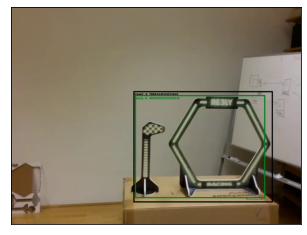

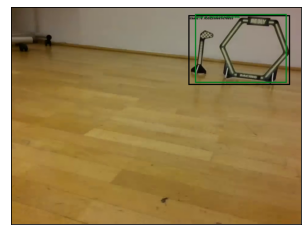

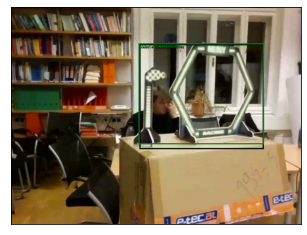

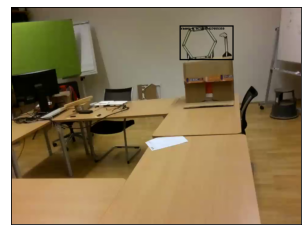

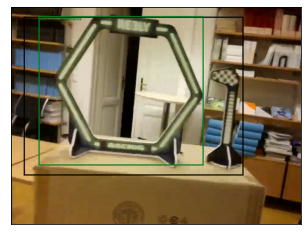

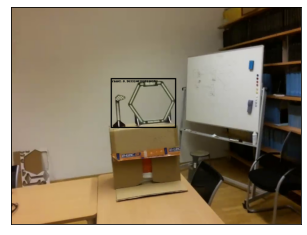

In [36]:
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import os
from os import listdir
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
from enum import Enum
from torchvision.utils import draw_bounding_boxes


plt.rcParams["savefig.bbox"] = 'tight'
images_dir = "/content/drive/MyDrive/PPMROB/ppmrob-project-main/torch/data/test/images/"
score_threshold = .2

class Label(Enum):
    FRONT = 1
    BACK = 2

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        #img.resize((1000,700), resample=Image.BOX)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def infer(img):
    # Transform image with corresponding wieghts
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    transforms = weights.transforms()
    trans_image = transforms(img)
    # Run inference
    with torch.no_grad():
        prediction = model([trans_image.to(device)])
    return prediction

def extract_labels(prediction):
    #print(prediction)
    length = len(prediction[0]['labels'])
    labels = []
    for i in range(length):
        if prediction[0]['scores'].cpu().numpy()[i] > score_threshold:
            label = Label(prediction[0]['labels'].cpu().numpy()[i]).name
            score = prediction[0]['scores'].cpu().numpy()[i]
            txt = "{}:{}".format(label, score)
            labels.append(txt)
    return labels

model.eval()
for img_name in os.listdir(images_dir):
    # Fetch image
    image = read_image(images_dir + img_name)
    prediction = infer(image)
    print(prediction)
    # Print detection in img
    #print(len(prediction[0]['labels']))
    #print(prediction[0]['labels'].cpu().numpy())
    labels = extract_labels(prediction)
    print(labels)

    #plt.imshow(draw_bounding_boxes(image, boxes=prediction[0]['boxes'][prediction[0]['scores'] > score_threshold], labels=labels, width=4, font_size=150).permute(1, 2, 0))
    show(draw_bounding_boxes(image, boxes=prediction[0]['boxes'][prediction[0]['scores'] > score_threshold], labels=labels, width=4, font_size=150))


## Calc Position

https://photo.stackexchange.com/questions/12434/how-do-i-calculate-the-distance-of-an-object-in-a-photo

In [52]:
"""
import torch
prediction = [{'boxes': tensor([[149.4061, 179.8934, 711.5840, 617.7186],
          [160.1231, 181.8718, 653.9130, 608.7147]], device='cuda:0'),
  'labels': tensor([1, 2], device='cuda:0'),
  'scores': tensor([0.7162, 0.4936], device='cuda:0')}]
"""
# ["xtl", "ytl", "xbr", "ybr"]
#boxes = prediction[0]['scores'].cpu().numpy()
box0 = [405.6159, 281.9630, 866.6481, 648.6038] # middle
box1 = [587.3494,  30.2924, 923.1415, 260.5743] # small
box2 = [425.4016, 126.5008, 836.1588, 472.9669] # middle
box3 = [558.8442,  64.0435, 736.6177, 178.1957] # very small
box4 = [ 42.0816,  35.4822, 769.9694, 559.7094] # very big
box5 = [330.2679, 238.4673, 546.8438, 402.1519] # small


boxes = [box0, box1, box2, box3, box4, box5]

def calc_area(box):
    xtl, ytl, xbr, ybr = box
    area = abs(xtl - xbr) * abs(ytl - ybr )
    print("Area: {}".format(area))

def calc_height(box):
    xtl, ytl, xbr, ybr = box
    height = abs(ytl - ybr)
    print("Height: {}".format(height))

def calc_distance(box):
    xtl, ytl, xbr, ybr = box
    f = 2
    real_height = 300
    image_height = 235
    object_height = abs(ytl - ybr)
    sensor_height = 2.77
    distance = (f*real_height*image_height)/(object_height*sensor_height)
    print("Distance to object (mm): {}".format(distance))

for box in boxes:
    calc_distance(box)



Distance to object (mm): 138.83486801199507
Distance to object (mm): 221.04441154868132
Distance to object (mm): 146.91921396007365
Distance to object (mm): 445.9180556819078
Distance to object (mm): 97.10012581531879
Distance to object (mm): 310.97932900109276
